In [1]:
import sqlite3
import pandas as pd, numpy as np,matplotlib.pyplot as plt
from scipy import stats
import statsmodels,random

In [2]:
#load data
conn = sqlite3.connect("interview.db")
cursor = conn.cursor()
sql = "select * from prod"
cursor.execute(sql)
col = [cursor.description[i][0] for i in range(3)]
allprod = pd.DataFrame(cursor.fetchall(),columns = col)
allprod.head()

,ValuationDate,ProdID,CValue
0,2020-01-02 00:00:00,A,1.063
1,2020-01-03 00:00:00,A,0.985
2,2020-01-04 00:00:00,A,0.985
3,2020-01-05 00:00:00,A,0.985
4,2020-01-06 00:00:00,A,0.985


In [3]:
#pivot table
pivot_prod = allprod.pivot(index='ValuationDate', columns='ProdID', values='CValue')
pivot_prod.index = pd.to_datetime(pivot_prod.index)
pivot_prod.tail()

ProdID,A,B,C,D,E
ValuationDate,,,,,
2021-02-18,1.181,0.8917,1.265,1.0211,1.0090
2021-02-19,1.187,0.8911,1.242,1.0191,1.0090
2021-02-20,1.187,0.8911,1.242,1.0191,1.0090
2021-02-21,1.187,0.8911,1.242,1.0191,1.0090
2021-02-22,1.189,0.8924,1.162,1.0262,1.0087


Text(0.5, 1.0, 'NAVs')

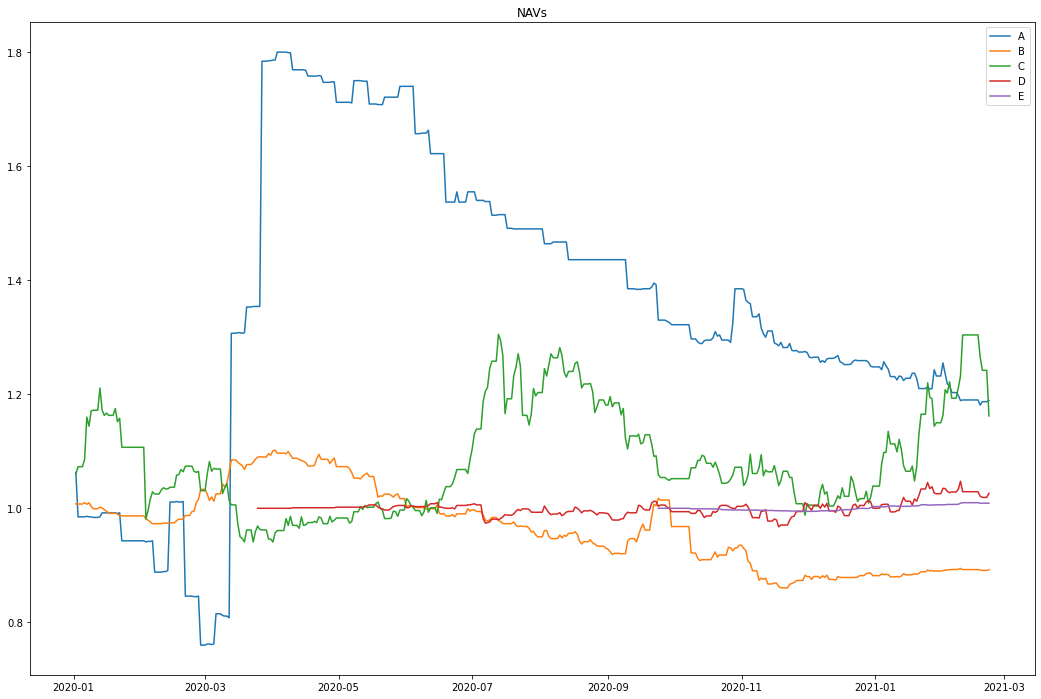

In [4]:
#plot
plt.figure(figsize=(18,12))
for i in pivot_prod.columns:
    plt.plot(pivot_prod[i],label = i)
plt.legend()
plt.title('NAVs')

In [6]:
#以下全部比率基于log return形式
#年化收益率(log形式) 
re = np.log(pivot_prod/pivot_prod.shift(1))
#发现日期为连续日期，年化即为日平均*365
Annual_return = re.mean()*365

#年化波动率（log形式）
Annual_std = re.std()*365**0.5

#最大回撤
recum = re.cumsum()
drawdown = (recum.expanding().max()-recum)
maxdrawdown = drawdown.max()


#Sharpe Ratio 以2020年一年期国债利率为无风险利率算年化
rf = np.log(1.0244)
Sharpe = (Annual_return-rf)/Annual_std

#Sortino Ratio
#downside deviation
down = re-rf/365
down[down>0] = 0
downstd = down.std()*365**0.5
Sortino = (Annual_return-rf)/downstd

#Calmar Ratio
Calmar = (Annual_return-rf)/maxdrawdown
pd.DataFrame([Annual_return,Annual_std,maxdrawdown,Sharpe,Sortino,Calmar],index =['Annual_return','Annual_std','maxdrawdown','Sharpe','Sortino','Calmar'] )

ProdID,A,B,C,D,E
Annual_return,0.098049,-0.106446,0.080417,0.028263,0.020939
Annual_std,0.596456,0.116228,0.318417,0.086672,0.008086
maxdrawdown,0.421425,0.247278,0.278276,0.045364,0.005415
Sharpe,0.123969,-1.123248,0.176844,0.047951,-0.391806
Sortino,0.303468,-1.520542,0.251244,0.071422,-0.901246
Calmar,0.175457,-0.527960,0.202353,0.091616,-0.585123


In [7]:
#最大的前五次回撤
top5drawdown = {}

for i in drawdown.columns:
    a = 0
    b = 1
    l = []
    dd = drawdown[i].dropna()
    while b < len(dd):
        if (dd[a]*dd[b]==0) and (dd[a:b].max()!=0):
            l.append(dd[a:b].max())
            a = b
        b+= 1 
    top5drawdown[i] = sorted(l)[::-1][:5]
top5drawdown

{'A': [0.28636541656703407,
  0.17916449024118764,
  0.11075136429270263,
  0.0020304575503819894,
  0.001014713430546571],
 'B': [0.03732905921291282,
  0.020534602441707638,
  0.015327038234289339,
  0.00816331063916087,
  0.004730291727568239],
 'C': [0.25225860396771305,
  0.03273477341613447,
  0.013889112160667155,
  0.008464844695947799],
 'D': [0.04536360376703267,
  0.036294306192770034,
  0.0195322602169541,
  0.019027956134021945,
  0.017721738954246963],
 'E': [0.005414632701498764,
  0.0009004052431641551,
  0.0007925500712064482,
  0.0006959288445113673,
  0.0005977882015217794]}

In [8]:
#历史VaR
historical_Var = re.quantile(0.01)
historical_cVar = re[re<historical_Var].mean()

mean        -0.000292
median       0.000000
max          0.025055
min         -0.049121
std          0.006076
skewness    -1.896608
kurtosis    19.688556
dtype: float64


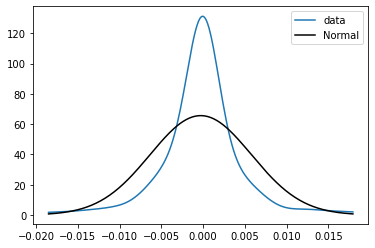

In [9]:
#simulations
#首先对分布进行检查
def statistics(close):
    mc = np.mean(close)
    stdc = np.std(close)
    print(pd.Series({'mean':mc,'median':np.median(close),'max':np.max(close),'min':np.min(close),'std':np.std(close),'skewness':stats.skew(close.T),'kurtosis':stats.kurtosis(close.T)}))
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
    
#明显呈现尖峰肥尾分布
statistics(re['B'].dropna())

In [10]:
#此处先采用正态分布随机数，以后可对峰度进行修正
#模拟return
simc = re.copy()
lenth = len(re)
for i in simc.columns:
    simc[i] = np.random.randn(lenth)*re[i].std()+re[i].mean()
simc.head()

ProdID,A,B,C,D,E
ValuationDate,,,,,
2020-01-02,0.016922,-0.009758,-0.007927,-0.001257,0.000089
2020-01-03,-0.056346,0.000599,0.006831,0.010494,0.001121
2020-01-04,0.007958,0.006914,-0.021326,-0.007690,0.000136
2020-01-05,0.037140,0.000527,0.001012,0.002481,0.000410
2020-01-06,-0.010131,-0.001484,0.004851,-0.000082,0.000356


In [11]:
#模拟VaR
Simc_Var = simc.quantile(0.01)
Simc_cVar = simc[simc<Simc_Var].mean()
pd.DataFrame([historical_Var,historical_cVar,Simc_Var,Simc_cVar],index = ['historical_Var','historical_cVar','Simc_Var','Simc_cVar'])

ProdID,A,B,C,D,E
historical_Var,-0.053320,-0.017377,-0.045977,-0.013215,-0.000846
historical_cVar,-0.095299,-0.030573,-0.077915,-0.018873,-0.001151
Simc_Var,-0.066882,-0.012790,-0.036021,-0.011074,-0.000943
Simc_cVar,-0.071953,-0.014375,-0.040791,-0.012187,-0.001000


In [12]:
#债券定价
def bondprice (irr,n=10,r=2.86,fv=100):
    irr = irr/100
    r = r/100
    pv = 0
    for i in range(1,n+1):
        pv += r*fv/(irr+1)**i
    pv = pv+100/(irr+1)**n
    return(pv)

#test fucntion when irr = r 
bondprice(2.86)

100.00000000000003

In [13]:
#build bisection function
def bis (f,a,b,tol=1e-8,maxi=10000):
    #check the solution
    if (f(a)*f(b)>0) : 
        return(warning("solution on [a,b] widen search"))
    c = (a+b)/2
    for i in range(maxi):
        if ((f(c)*f(a))<0):
            b = c
        else:
            a = c
        c = (a+b)/2
        if (abs(f(c))<tol or abs(a-b)<tol):
            return(c)
            break
    return(c)

#solve for f(x)= 0
irr = bis(lambda x:bondprice(x)-96.23 , 1,5)
irr

3.3089555725455284

In [14]:
#Modified duration 这里用近似去算一阶导
x = 1e-2
md = -(bondprice(irr+x)-bondprice(irr-x))/x/2
md

8.20634367608264

In [15]:
#基点价值（DV01）
x = 1e-2
DV01 = abs(bondprice(irr+x)-bondprice(irr))
DV01

0.08202163099987558

In [16]:
#此处采用线性插值法对利率插值
keyyear = [1,3,5,7,10]
keyrate = [2.6070,2.8802,3.0846,3.2282,3.2635]
ky = pd.Series(np.nan,index = range(1,11))
ky[keyyear] = keyrate
ky = ky.interpolate()
ky

1     2.607000
2     2.743600
3     2.880200
4     2.982400
5     3.084600
6     3.156400
7     3.228200
8     3.239967
9     3.251733
10    3.263500
dtype: float64

In [17]:
#获取keyrate导致的curve变动率
keypoint = pd.DataFrame(None,index = range(1,11),columns=keyyear)
for i in keyyear:
    keypoint.loc[keyyear,i] = keyrate
    keypoint.loc[i,i] -= 0.01
#同样采用线性插值获取对curve的变动
keypoint = keypoint.astype('float').interpolate()
keypoint

,1,3,5,7,10
1,2.597000,2.607000,2.607000,2.6070,2.607000
2,2.738600,2.738600,2.743600,2.7436,2.743600
3,2.880200,2.870200,2.880200,2.8802,2.880200
4,2.982400,2.977400,2.977400,2.9824,2.982400
5,3.084600,3.084600,3.074600,3.0846,3.084600
6,3.156400,3.156400,3.151400,3.1514,3.156400
7,3.228200,3.228200,3.228200,3.2182,3.228200
8,3.239967,3.239967,3.239967,3.2333,3.236633
9,3.251733,3.251733,3.251733,3.2484,3.245067
10,3.263500,3.263500,3.263500,3.2635,3.253500


In [18]:
#计算债券价值
def curvebondprice (curve,n=10,r=2.86,fv=100):
    curve = curve/100
    r = r/100
    pv = 0
    for i in range(1,n+1):
        pv += r*fv/(curve[i]+1)**i
    pv = pv+100/(curve[i]+1)**n
    return(pv)

#利率线性插值的结果和真实的债券价格有些许差别
base = curvebondprice(ky)
base

96.75318537270684

In [19]:
krDV01 = []
for j in keyyear:
    krDV01.append(curvebondprice(keypoint[j])-base)
krDV01 = pd.Series(krDV01,index = keyyear)
krduration = krDV01/1e-2
print('key rate duration \n',krduration,'\nkey rate DV01 \n',krDV01)

key rate duration 
 1     0.053539
3     0.152364
5     0.237634
7     0.401193
10    7.410637
dtype: float64 
key rate DV01 
 1     0.000535
3     0.001524
5     0.002376
7     0.004012
10    0.074106
dtype: float64
